![WeTheGeeksV3.jpg](https://raw.githubusercontent.com/ptsireunion/CPGE-PT-Reunion/main/WeTheGeeksV3.jpg)
 
<div class="alert alert-block alert-info">
    <b> PYTHON – Travaux Dirigés N°17
</div>

# - Propagation d'une onde dans le vide - Equation de d'Alembert
> Physique Chimie `CPGE PT` lien vers le blog <a> https://cpge-reunion-ptsi.blogspot.com/p/python_6.html </a>
    >> Sujet inspiré par diverses lectures. Un grand merci à leurs contributeurs.trices

Dans ce notebook, on cherchera à `discrétiser l’équation de D'Alembert, la résoudre numériquement et calculer l'évolution de l'onde sur un intervalle de temps de 20s.`

# Hypothèses
Pour simplifier les écritures et rendre plus lisibles les résultats:
>le domaine étudié aura une longueur de $L=50~\text{m}$, 
>
>la longueur d'onde choisie est $\lambda_0=1~\text{m}$, 
>
>la célérité des ondes sera $c=1~\text{m.s}^{-1}$
>
>la pulsation est notée $\omega_0$.
>
>La forme d'onde est placée au centre du domaine en $x_0=\frac{L}{2}$ et sans vitesse initiale. On laisse alors l'équation de d'Alembert numérisée décider de sa propagation.

# Conditions aux limites
>On calculera l'évolution de l'onde sur un intervalle de temps `duree` de $20~\text{s}$ qui doit permettre à l'onde d'approcher les bordures sans les atteindre. 
>
>On utilisera des conditions aux limites dites "de réflexion totale", plus simples à implémenter, en fixant la valeur de $E(x=0)=E(x=L)=0$.


# Conditions initiales : forme d'onde simple, fenêtre de Hann
>Pour se rapprocher de la réalité, on choisit d'étudier un onde non purement sinusoïdale. Pour créer une forme d'onde simple on définit une fonction `Hann` qui calcule une fenêtre de Hann de largeur $H$, centrée sur un point $x_0$.
Pour vous renseigner sur cette fonction, rendez-vous à l'adresse suivante <a> https://fr.wikipedia.org/wiki/Fen%C3%AAtrage </a>
On verra plus loin comment la générer.

# Etude théorique

> **Question 1**
>
> Démontrer l’équation de D'Alembert à une dimension en cartésien dans le vide à l'aide des équations de Maxwell : $$\dfrac{\partial^2 E}{\partial t^2}=c^2\dfrac{\partial^2E}{\partial x^2}$$

>**Question 2** 
> On appelle $\sigma=\frac{1}{\lambda}$ le nombre d'onde. Exprimer $\omega_0$ en fonction de $\sigma$, $\lambda$ et $c$. Calculer sa valeur



## Etude numérique : Discrétisation de l'équation de Laplace
On ne travaillera pas avec une matrice `E[i,j]` avec i associé à x et j à t.  On choisit de faire les calculs en fonction du temps et de la position séparément. On calculera d'abord le Laplacien pour ensuite l'injecter dans l'équation d'onde.

>**Question 3** 
>> 3.1) Soit une fonction $f$. En écrivant la formule de Taylor à l’ordre 2 pour $f(x+dx)$ et $f(x-dx)$, démontrer que : 
> $$ f''(x)\simeq\frac{f(x+dx)+f(x-dx)-2f(x)}{dx^2}$$
>
>> 3.2)
> En déduire l'approximation de $\left(\frac{\partial^2 E}{\partial x^2}\right)_{t}$ en fonction de `E[i+1]`, de `E[i]` et de `E[i-1]` et du pas spatial `delta_x`.
>
>> 3.3)
> Appliquer la même méthode pour la dérivée seconde suivant la variable t et en déduire l'approximation de $\left(\frac{\partial^2 E}{\partial t^2}\right)_{x}$ en fonction de `E_new`, de `E` et de `E_old` et du pas temporel `delta_t`.
>
>> 3.4)
> On appelle `d2Ex` le Laplacien unidimensionel. Déduire des questions précédentes la résolution itérative qui sera implémentée à chaque instant $t_k$ dans l'algorithme :
`E_new = 2*E - E_old + ((c*delta_t)**2)*d2Ex`


## Déclaration des variables numériques
Import des librairies

In [2]:
#On ajoute la ligne %matplotlib inline qui permettra d'afficher les graphiques directement dans le notebook.
%matplotlib inline

# import des librairies 
import numpy as np
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

Déclaration des constantes

In [3]:
# Domaine de calcul
L = 50 # longueur
duree = 20

# Onde
E_amp = 1 # amplitude
lambda0 = 1 # longueur d'onde
sigma0 = 1 / lambda0 # nombre d'onde
c = 1 # célérité 
omega0=2*np.pi*sigma0*c # pulsation associée à la longueur d'onde

Les variables numériques spatiales, nombre de points et pas d'espace sont `Num_x` et `delta_x`, tandis que les variables temporelles sont `Num_t` et `delta_t`.
>**Question 4** : créez les tableaux des valeurs spatiales et temporelles `Num_x` et `Num_t` ainsi que `delta_x` et `delta_t`. Pour ces deux dernières valeurs, vous prendrez deux points successifs de `Num_x` et `Num_t`. De quelles valeurs numériques s'agit t'il ? Vérifiez le.

In [4]:
# Intégration spatiale
Num_x = 5001 # points de calcul
x=np.linspace(0,L,Num_x) # vecteur position
delta_x = x[1]-x[0] # intervalle spatial d'intégration


# Intégration temporelle
Num_t = 10001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

## Génération de la fenêtre de Hann

In [4]:
x0=L/2 # position initiale de la forme d'onde

## Fenêtre de définition de la forme d'onde
def Hann(x,x0,H):
    func=np.zeros(len(x))
    for i in range(len(x)):
        if abs(x[i]-x0)<H/2:
            func[i]=.5*(1-np.cos(2*np.pi*(x[i]-x0+H/2)/H))
    return func

## Forme d'onde à l'instant t, t-dt et t+dt
E0  = E_amp*Hann(x,x0,lambda0)

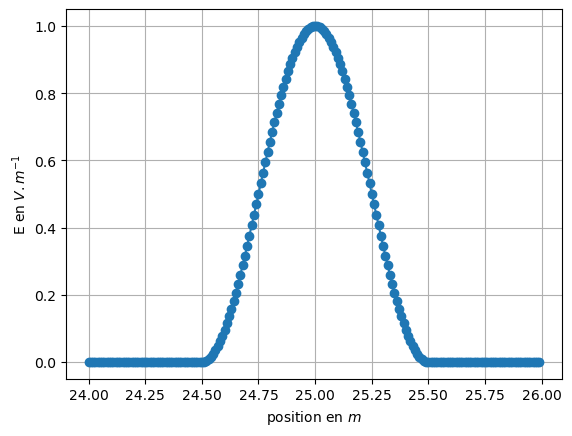

In [5]:
# Tracé de la forme d'onde avec zoom sur la partie centrale du domaine de calcul
plt.figure()
Nx=int(lambda0//delta_x)
plt.plot(x[int(2.4*Num_x//5):int(2.6*Num_x//5)],E0[int(2.4*Num_x//5):int(2.6*Num_x//5)],'-o')
plt.xlabel(r"position en $m$")
plt.ylabel(r"E en $V.m^{-1}$")
plt.grid(True)
plt.show()

> **Question 5** : en étudiant la forme mathématique de la fenêtre de Hann, démontrer sa valeur maximale en $x_0$

# Ecriture de l'algorithme 

> **Question 6** : Remplir le code suivant qui permet de résoudre l'équation de d'Alembert 

In [15]:
# On suppose la forme d'onde présente pour tout t<0 et immobile
E=E0
E_old=E0
E_new=E0
d2Ex=np.zeros(Num_x) # initialisation du laplacien de E qui sera calculé plus loin

E_store=[] # liste dans laquelle on stocke quelques formes d'onde intermédiaires
time_store=[] # liste dans laquelle on stocke les instants correspondants

k, time = 0,0
while time < duree : 
    for i in range (...................):
        d2Ex[i] = ...................................

    E_new = ..................................
    E_old = ..................
    E = ................
    if k%(duree/(5*delta_t)) == 0 :
        E_store.append(....................)
        time_store.append(....................)
    k =.................
    time =.................

tracés pour les 5 premiers pas temporels, t=0 compris

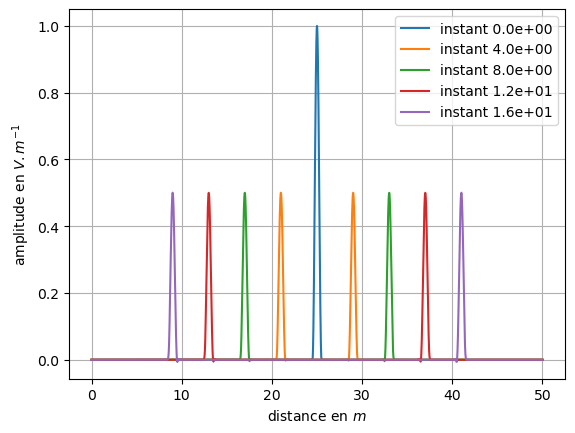

In [16]:
plt.figure()
plt.grid(True)
for i in range(len(E_store)) :
    plt.plot(x,E_store[i], label="instant "+str(format(time_store[i], "#.1e")))
plt.xlabel(r"distance en $m$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.legend()
plt.show()

# Conclusion
> La forme d'onde se scinde en deux, l'une se propageant dans le sens des $x$ croissants et l'autre dans l'autre sens. Les deux se propagent à la même vitesse que l'on peut calculer et comparer à celle attendue.
 
> **Question 7**  : A l'aide de la courbe précédente, retrouver l'ordre de grandeur de la célérité $c$ de l'onde